# Simulating NFL games with Monte Carlo


I want to model NFL games using teams's past performance. The idea is to take the game state (offense, defense, score, and clock) and put together a portfolio of what those teams have done in the past, then randomly choosing one of those past outcomes to move the game forward. Picture stacking rocks to build a wall. You have to choose a bunch of rocks and put them together one at a time until eventually you're left with something resembling a wall. The same principle is here. A football game is built of drives. One drive happens, then another, and another, until the teams run out of time.

In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import math
from time import time
import random
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read drive-level data from csv
alldrives = pd.read_csv('../data/espn_drives2009-2017.csv')

# Load game-level data from csv
gamedata = pd.read_csv('../data/espn_gamedata2009-2017.csv')

# Include time information on these drives
alldrives = alldrives.merge(
                right=gamedata[['gameId','season','week']],
                how='left',
                left_on='gameId',
                right_on='gameId')

# Print out what we're working with
alldrives.sample(5)

,Unnamed: 0,away,away_score_after,away_score_before,drive,home,home_score_after,home_score_before,offense,plays,...,FG,punt,turnover,EoH,secs_rem,starting_fieldposition,time_in_secs,left_in_half,season,week
1546,1546,NYG,31,28,11,OAK,7,7,OAK,1,...,0,0,1,0,1843.0,-34.0,16,43.0,2009,5
25138,25138,OAK,13,13,14,JAX,3,3,OAK,3,...,0,1,0,0,1310.0,-39.0,119,1310.0,2013,2
39635,39635,NYJ,0,0,1,BUF,0,0,BUF,3,...,0,1,0,0,3569.0,-32.0,77,1769.0,2015,10
17163,17163,SD,16,16,7,BUF,0,0,BUF,3,...,0,1,0,0,1906.0,-38.0,35,106.0,2011,14
11640,11640,JAX,7,7,18,WSH,10,10,WSH,3,...,0,1,0,0,1519.0,-12.0,89,1519.0,2010,16


## Some necessary functions

In [3]:
# Function to return one item from a list, where each has a weight
def select(container, weights, quiet=False):
    total_weight = float(sum(weights))
    rel_weight = [w / total_weight for w in weights]

    # Probability for each element
    probs = [sum(rel_weight[:i + 1]) for i in range(len(rel_weight))]
    
    r = random.random()
    for (i, element) in enumerate(container):
        if r <= probs[i]:
            if not quiet:
                print("^",element,rel_weight[i])
            break

    return element

In [4]:
def get_possible_drives(home,away,home_poss,time_rem,season):

    # Set some keywords for the filter
    if home_poss:
        off_team = home
        def_team = away  
    else:
        off_team = away
        def_team = home
    
    # Filter for drives for this offense and defense
    teamdrives = alldrives.loc[ 
               # Condition 1: team is the offense
               ( 
                 alldrives.offense.astype(str) == off_team 
               ) 
               |  # OR
               # Condition 2:
               ( # Defensive team is home or away
                 ( 
                   (alldrives.home.astype(str) == def_team) |
                   (alldrives.away.astype(str) == def_team)
                 ) 
                 &  # AND
                   # not the offense
                 (alldrives.offense.astype(str) != def_team)
               )
             ]
    
    # Filter for drives from the past 5 seasons
    teamdrives = teamdrives.loc[ (teamdrives.season >= season-5) ]

    return teamdrives

In [5]:
# Define a class that constitutes a game
class football_game:
    """Class for representing a football game"""
    def __init__(self, home ,away, season=2018, week=1, quiet=False):

        self.home = home
        self.away = away
        self.quiet = quiet
        self.season = season
        self.week = week
        self.half = 1
        self.time_rem = 1800
        self.home_score = 0
        self.away_score = 0
        self.drive_base_weights = {}
        
        # Decide which team gets the ball to start
        coin = random.randint(1,2)
        if coin == 1:
            self.home_poss = True
        else:
            self.home_poss = False
            
    
    def get_drive_base_weights(self, drives_df):
        """Return a dictionary with base weights for past plays"""
        drives = drives_df.index.values.tolist()
        base_weights = {}
        for i, d in enumerate(drives):
            drive = drives_df.loc[d,:]
            
            # Weight for recency
            if self.season < drive['season']:
                w_age = 0  # Can't use future data
            elif self.season == drive['season']:
                if self.week <= drive['week']:
                    w_age = 0
                else:
                    w_age = 2 - (self.week - drive['week']) / 16
            else:
                w_age = 1 / ( 2*(self.season - drive['season']) )
            
            # Place to add weight for home/away
            w_home = 1
            if (drive['home'] == self.home) or (drive['away'] == self.away):
                w_home = 2
                
            # Add weight to previous matchups of same teams
            w_matchup = 1
            teams = [drive['home'],drive['away']]
            if (self.home in teams) and (self.away in teams):
                w_matchup = 2
            
            base_weights[d] = w_age * w_home * w_matchup
            
        return base_weights
                 
            
    def get_drive_weights(self, drives_df):
        drives = drives_df.index.values.tolist()
        drive_weights = [ 1 for d in drives ]
        # Get current score difference
        if self.home_poss:
            curr_score_diff = self.home_score - self.away_score
        else:
            curr_score_diff = self.away_score - self.home_score        

        for i, d in enumerate(drives):
            drive = drives_df.loc[d,:]
            w_base = self.drive_base_weights[d]

            # Gaussian function for selecting plays with similar time remaining in half
            w_time = 0
            if self.time_rem > 300:
                # Most of the time, time remaining won't dictate decisions.
                w_time = 1
            elif (not drive.EoH==1) or (drive.time_in_secs < self.time_rem + 10):
                    
                numerator = drive['left_in_half'] - self.time_rem
                # Scale variance in Gaussian by time remaining. More possibilities with more time left
                stdev = self.time_rem / 3
                w_time = math.exp( (numerator)**2 / (-2*stdev**2) )

            # Get score difference before this drive
            if drive['offense'] == drive['home']:
                hist_score_diff = drive['home_score_before'] - drive['away_score_before']
            elif drive['offense'] == drive['away']:
                hist_score_diff = drive['away_score_before'] - drive['home_score_before']
                
            # Want Gaussian for plays with similar score situations
            w_score = math.exp( ( curr_score_diff - hist_score_diff )**2 / -98 )
            
            # Finally, set weight as product of the other pieces
            weight = w_base * w_time * w_score
            
            # Try and catch nans
            if math.isnan(weight):
                weight = 0
                
            drive_weights[i] = weight
                
        if not self.quiet:
            print("sum of weights = ",sum(drive_weights))
            
        return drive_weights
    
    
    def next_drive(self):
#    def next_drive(game_sit, game=game):
        """Returns a Series describing the next drive."""
    
        poss_drives = self.away_drives
        if self.home_poss:
            poss_drives = self.home_drives
            
        # Choose subset of drives based on time remaning in 1st/2nd half
        if self.time_rem > 300:
            poss_drives = poss_drives[ poss_drives.left_in_half >= 300 ]
        elif self.half == 1:
            poss_drives = poss_drives[ (poss_drives.left_in_half < 300) &
                                       (poss_drives.secs_rem > 1800) ]
        else:
            poss_drives = poss_drives[ (poss_drives.left_in_half < 300) &
                                       (poss_drives.secs_rem < 1800) ]
    
        # Get weights for the possible drives
        drive_ids = poss_drives.index.values.tolist()
        weights = self.get_drive_weights(poss_drives)
    
        # Randomly choose a drive, with weights assigned to each.
        chosen_drive_id = select(drive_ids, weights, quiet=self.quiet)
    
        return poss_drives.loc[chosen_drive_id, :]
            
            
    def get_game_sit(self):
        game_sit = (self.home,
                    self.away,
                    self.home_poss,
                    self.time_rem,
                    self.home_score,
                    self.away_score )
        return game_sit
 

    def game_sit_series(self, drive):
        # Figure out which team has possession
        if self.home_poss:
            possessor = self.home
        else:
            possessor = self.away
        
        sit_dict = {'home':self.home,
                    'away':self.away,
                    'offense':possessor,
                    'half':self.half,
                    'time_rem':self.time_rem,
                    'home_score':self.home_score,
                    'away_score':self.away_score,
                    'result':drive.result}
        return pd.Series(sit_dict)
    
    
    def game_sit_dict(self):
        # Figure out which team has possession
        if self.home_poss:
            possessor = self.home
        else:
            possessor = self.away
        
        sit_dict = {'home':self.home,
                    'away':self.away,
                    'offense':possessor,
                    'half':self.half,
                    'time_rem':self.time_rem,
                    'home_score':self.home_score,
                    'away_score':self.away_score}
        return sit_dict
    
    
    def update_game_sit(self,drive):
        """Takes a Series and updates game situation vars accordingly"""
        
        # Update clock and score
        self.time_rem -= drive.time_in_secs
        self.home_score += drive.home_score_after - drive.home_score_before
        self.away_score += drive.away_score_after - drive.away_score_before
        
        # Flip the possession arrow
        if self.home_poss:
            self.home_poss = False
        else:
            self.home_poss = True
            
            
    def record_drive(self,drive,drive_num=1):
        """Given a drive, update the proper quantities, 
        assuming dataframes for chosen drives and game history have 
        already been created"""
        # Get gamestate before this drive
        gamestate = self.game_sit_dict()
        
        # Clock changes
        gamestate_delta = {'time':drive.time_in_secs}
        if drive.time_in_secs < 10:
            gamestate_delta['time'] = 10
        
        # Score changes
        # Home team in selected drive might not be home team in sim. game
        if self.home_poss and (drive.offense == drive.home):
            flip = False
        elif self.home_poss and (drive.offense == drive.away):
            flip = True
        elif (not self.home_poss) and (drive.offense == drive.home):
            flip = True
        elif (not self.home_poss) and (drive.offense == drive.away):
            flip = False
        else:
            print("Something went wrong in determining flipped possession")
            
        if not flip:
            gamestate_delta['home_score'] = drive.home_score_after - drive.home_score_before
            gamestate_delta['away_score'] = drive.away_score_after - drive.away_score_before
        else:
            gamestate_delta['away_score'] = drive.home_score_after - drive.home_score_before
            gamestate_delta['home_score'] = drive.away_score_after - drive.away_score_before

        # Check for negative values in score delta
        scores_delta = (gamestate_delta['home_score'], gamestate_delta['away_score'])
        if sum([1 if (val < 0 or val > 8) else 0 for val in scores_delta]) > 0:
            # Recalculate score change based on drive result
            # Default to zero points
            gamestate_delta['home_score'] = 0
            gamestate_delta['away_score'] = 0
            if (drive.FG == 1):
                if self.home_poss:
                    gamestate_delta['home_score'] = 3
                else:
                    gamestate_delta['away_score'] = 3
            elif (drive.TD == 1):
                if self.home_poss:
                    gamestate_delta['home_score'] = 7
                else:
                    gamestate_delta['away_score'] = 7
                
        
        # Figure out whether possession arrow changes. Default True
        gamestate_delta['poss'] = True
        if ( (self.home_poss) & 
             (gamestate_delta['away_score'] != 0) ):
            gamestate_delta['poss'] = False
        elif ( (not self.home_poss) &
               (gamestate_delta['home_score'] != 0) ):
            gamestate_delta['poss'] = False
                    
        
        # Add entry to simulated game history
        this_series = pd.Series(gamestate)
        this_series['home_score_after'] = self.home_score + gamestate_delta['home_score']
        this_series['away_score_after'] = self.away_score + gamestate_delta['away_score']
        this_series['result'] = drive.result
        this_series['time'] = gamestate_delta['time']
        
        if drive_num == 1:  # Need to start gamestate dataFrame
            self.gamestate_df = pd.Series.to_frame(this_series)
        else:            # Add this series to gamestate dF
            series_df = pd.Series.to_frame(this_series)
            dfs = [ self.gamestate_df, series_df ]
            self.gamestate_df = pd.concat( dfs, axis=1 )
        
        # Update the game's state vars
        self.home_score += gamestate_delta['home_score']
        self.away_score += gamestate_delta['away_score']
        self.time_rem -= gamestate_delta['time']
        if gamestate_delta['poss']:
            self.home_poss = not self.home_poss
    
    
    def check_for_EoH(self):
        pass

## Function to simulate one game

In [6]:
def simulate_game( home, away, **kwargs):

    # Need new wrapper for simulating a game
    if not 'season' in kwargs:
        kwargs['season'] = 2018
    if not 'week' in kwargs:
        kwargs['week'] = 1
    if not 'quiet' in kwargs:
        kwargs['quiet'] = False
        
    newgame = football_game( home, away, **kwargs )
    
    # Assign possible drives for this game
    newgame.home_drives = get_possible_drives( home, away, 
                                               True, 1800, 
                                               newgame.season )
    newgame.away_drives = get_possible_drives( home, away, 
                                               False, 1800, 
                                               newgame.season)
    newgame.drive_base_weights = newgame.get_drive_base_weights(newgame.home_drives)
    newgame.drive_base_weights.update(newgame.get_drive_base_weights(newgame.away_drives))

    # Choose the first drive
#    game_sit = newgame.get_game_sit()
    first_drive = newgame.next_drive()

    # Make drive history DF, starting with this first drive.
    newgame.drives_selected = pd.Series.to_frame(first_drive)

    # Update game object after the first drive
    drive_num = 1
    newgame.record_drive( first_drive, drive_num )

    #while newgame.time_rem.astype(float) >= 5:
    for half in (1,2):
        newgame.half = half
        if half > 1:
            newgame.time_rem = 1800
    
        end_of_half = False
        while (not end_of_half) and (newgame.time_rem > 0):
            drive_num += 1
    
            # Choose a new drive
            this_drive = newgame.next_drive()
            # Add drive to chosen drives dataframe
            newgame.drives_selected = pd.concat( [newgame.drives_selected, 
                                                  this_drive], axis=1 )
        
            # Update the game object
            newgame.record_drive( this_drive, drive_num )
        
            # Check for end of Half
            if this_drive.EoH == 1:
                end_of_half = True
        
    
    # Post-game, need to transpose the dataFrames
    newgame.drives_selected = newgame.drives_selected.transpose()
    newgame.gamestate_df = newgame.gamestate_df.transpose()
    if newgame.home_score > newgame.away_score:
        newgame.winner = newgame.home
    elif newgame.away_score > newgame.home_score:
        newgame.winner = newgame.away
    else:
        newgame.winner = "TIE"
    
    
    newgame.result = {'home':newgame.home, 
                      'home_score':newgame.home_score, 
                      'away':newgame.away, 
                      'away_score':newgame.away_score,
                      'winner':newgame.winner}
    
    return newgame

## Parallelized function to simulate many games

In [44]:
def sim_one_game(home, away, **kwargs):
    game_obj = simulate_game(home,away,**kwargs)
    print(game_obj.result)
    return game_obj

# New, parallelized function for simulating many games at once
def sim_many_games(home, away, iterations=25, **kwargs):
        
    game_objects = Parallel(n_jobs=3) \
                           (delayed(sim_one_game) \
                            (home, away, **kwargs) \
                            for i in range(iterations) )
            
    # Make dataFrame from results, so that we can do things with them
    stats = {}
    sim_results = pd.DataFrame([g.result for g in game_objects])
    wins = sim_results.groupby(['winner'])['home'].agg('count')
    win_pcts = wins/float(iterations)
    
    # Write values to dictionary that will be returned as result of function
    stats['iterations'] = iterations
    stats['home_wins'] = wins[home] if home in wins.index.values else 0
    stats['away_wins'] = wins[away] if away in wins.index.values else 0
    stats['home_winpct'] = round(win_pcts[home],3) if home in wins.index.values else 0
    stats['away_winpct'] = round(win_pcts[away],3) if away in wins.index.values else 0
    stats['home_score_avg'] = round(sim_results.home_score.mean(),1)
    stats['away_score_avg'] = round(sim_results.away_score.mean(),1)
    stats['game_objects'] = sim_results
    
    return stats

## Visualize a set of many simulated games

In [8]:
def visualize_sim(game_dict):
    # Show score distribution for each team
    objects = game_dict['game_objects']
    for tm in ['home', 'away']:
        sns.distplot(objects[tm+"_score"].values,
                     bins=25,
                     hist_kws={"alpha":0.25},
                     kde_kws={"label":game_dict['game_objects'][tm].values[0]})

    # Place each team's average score on the plot
    home_avg = game_dict['home_score_avg']
    away_avg = game_dict['away_score_avg']
    plt.axvline(home_avg, linestyle='--', alpha=1, color='steelblue')
    plt.axvline(away_avg, linestyle='--', alpha=1, color='darkorange')

    # Set things with axes
    max_score = game_dict['game_objects'][['home_score','away_score']].max().values.max()
    plt.xlim( 0, max_score )
    plt.xlabel("Score")
    plt.tick_params(labelleft='off')
    plt.show()

# Finally start simming games!

In [9]:
# Sim one game
t = time()
g = sim_one_game("CAR","ATL",quiet=True)

print("Simulated 1 game in ",time()-t,"seconds")

{'home': 'CAR', 'home_score': 20, 'away': 'ATL', 'away_score': 18, 'winner': 'CAR'}
Simulated 1 game in  5.305215358734131 seconds


In [10]:
# Sim several games
t = time()
gs = sim_many_games("CAR","ATL",quiet=True,iterations=100)

print("Simulated 100 games in ",time()-t,"seconds")

{'home': 'CAR', 'home_score': 13, 'away': 'ATL', 'away_score': 37, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 15, 'away': 'ATL', 'away_score': 55, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 20, 'away': 'ATL', 'away_score': 24, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 24, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 10, 'away': 'ATL', 'away_score': 31, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 20, 'away': 'ATL', 'away_score': 11, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 29, 'away': 'ATL', 'away_score': 11, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 31, 'away': 'ATL', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 26, 'away': 'ATL', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'ATL', 'away_score': 44, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 22, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'ATL', 'away_score': 30, 'winner': 

{'home': 'CAR', 'home_score': 20, 'away': 'ATL', 'away_score': 30, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 10, 'away': 'ATL', 'away_score': 33, 'winner': 'ATL'}
Simulated 100 games in  326.220730304718 seconds


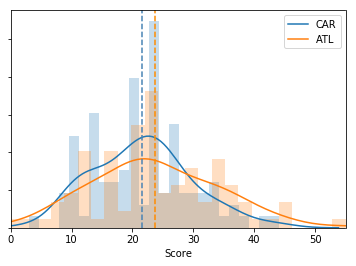

In [11]:
# Visualize sesveral games
visualize_sim(gs)

In [ ]:
# Maybe even sim a whole season
simmed_games = {}
real_games = {}
weeks = 6
for wk in range(1,weeks+1):
    real_game = gamedata[
                          (gamedata.season==2017) &
                          (gamedata.week==wk) &
                          ((gamedata.home=="CAR") | (gamedata.away=="CAR"))
                        ]
    
    if len(real_game.index > 0):
        real_games[wk] = real_game
        
        home_tm = real_game.home.values[0]
        away_tm = real_game.away.values[0]
        sim_game = sim_many_games(home_tm, away_tm,
                                  season=2017,
                                  week=wk,
                                  iterations=10,
                                  quiet=True)
        simmed_games[wk] = sim_game
        
        
for wk in range(1,weeks+1):
    print("Simulated Game")
    visualize_sim(simmed_games[wk])
    print("Real Result:")
    cols = ['home','away','result']
    print(real_games[wk][cols])
    print("\n")

# Simulate the upcoming season

In [12]:
games_2018 = pd.read_csv("../data/2018_schedule.csv")
games_2018.head(5)

,gameId,away,home,season,week
0,401030710,atl,phi,2018,1
1,401030718,pit,cle,2018,1
2,401030717,cin,ind,2018,1
3,401030716,ten,mia,2018,1
4,401030715,sf,min,2018,1


In [15]:
import json

In [45]:
### Given dataframe of games, simulate each one of them
def simulate_set(gamesdf, iterations=100):

    results = {}

    for i in gamesdf.index.values[:]:
        g = gamesdf.loc[i,:]
        gameid = str(g.gameId)
        home = g.home.upper()
        away = g.away.upper()
        yr = g.season
        wk = g.week
        print(yr,wk,home,away)
    
        # Simulate games, get returned dictionary
        game_results = sim_many_games(home, away,
                                      season=yr, week=wk,
                                      iterations=iterations,
                                      quiet=True)
        # Add some context for these simulated games
        game_results['home'] = home
        game_results['away'] = away
        game_results['season'] = yr
        game_results['week'] = wk
        results[gameid] = game_results


    # Make results DataFrames into dicts so that we can save this as json.
    for gid in results.keys():
        thisdict = results[gid]
    
        # Convert data types to python generics
        for k in thisdict.keys():
            if isinstance(thisdict[k], np.generic):
                thisdict[k] = np.asscalar(thisdict[k])
            
        df = results[gid]['game_objects']
        results[gid]['game_objects'] = df.to_json(double_precision=3)
    
    return results

In [28]:
# write to a file
with open("results.json","w") as f:
    json.dump(results, f)
    
# read it back
with open("results.json","r") as f:
    results = json.load(f)
    
print(results)

{'401030710': {'home_winpct': 0.333, 'away_winpct': 0.667, 'home_score_avg': 16.3, 'away_score_avg': 19.7, 'game_objects': '{"away":{"0":"ATL","1":"ATL","2":"ATL"},"away_score":{"0":31,"1":25,"2":3},"home":{"0":"PHI","1":"PHI","2":"PHI"},"home_score":{"0":17,"1":19,"2":13},"winner":{"0":"ATL","1":"ATL","2":"PHI"}}', 'home': 'PHI', 'away': 'ATL', 'season': 2018, 'week': 1}}


In [46]:
# Select just pathers games in 2018
panthers_games = games_2018[ (games_2018.home == "car") | 
                             (games_2018.away == "car")]

results = simulate_set(panthers_games, iterations=200)

2018 1 CAR DAL
{'home': 'CAR', 'home_score': 19, 'away': 'DAL', 'away_score': 19, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 3, 'away': 'DAL', 'away_score': 27, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 21, 'away': 'DAL', 'away_score': 24, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 10, 'away': 'DAL', 'away_score': 22, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 3, 'away': 'DAL', 'away_score': 21, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 17, 'away': 'DAL', 'away_score': 41, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 28, 'away': 'DAL', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 22, 'away': 'DAL', 'away_score': 23, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 19, 'away': 'DAL', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 32, 'away': 'DAL', 'away_score': 23, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 10, 'away': 'DAL', 'away_score': 19, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 7, 'away': 'DAL', 'away_score': 3

{'home': 'CAR', 'home_score': 37, 'away': 'DAL', 'away_score': 32, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 17, 'away': 'DAL', 'away_score': 23, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 23, 'away': 'DAL', 'away_score': 37, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 13, 'away': 'DAL', 'away_score': 20, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 22, 'away': 'DAL', 'away_score': 18, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 17, 'away': 'DAL', 'away_score': 23, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 6, 'away': 'DAL', 'away_score': 19, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 38, 'away': 'DAL', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'DAL', 'away_score': 21, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 33, 'away': 'DAL', 'away_score': 27, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 31, 'away': 'DAL', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 25, 'away': 'DAL', 'away_score': 12, 'winner': 

{'home': 'CAR', 'home_score': 15, 'away': 'DAL', 'away_score': 23, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 16, 'away': 'DAL', 'away_score': 20, 'winner': 'DAL'}
{'home': 'CAR', 'home_score': 20, 'away': 'DAL', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 17, 'away': 'DAL', 'away_score': 52, 'winner': 'DAL'}
2018 2 ATL CAR
{'home': 'ATL', 'home_score': 12, 'away': 'CAR', 'away_score': 23, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 18, 'away': 'CAR', 'away_score': 17, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 28, 'away': 'CAR', 'away_score': 21, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 34, 'away': 'CAR', 'away_score': 14, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 15, 'away': 'CAR', 'away_score': 13, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 18, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 21, 'away': 'CAR', 'away_score': 17, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 42, 'away': 'CAR', 'away_score':

{'home': 'ATL', 'home_score': 17, 'away': 'CAR', 'away_score': 23, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 10, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 13, 'away': 'CAR', 'away_score': 10, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 16, 'away': 'CAR', 'away_score': 26, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 13, 'away': 'CAR', 'away_score': 12, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 26, 'away': 'CAR', 'away_score': 20, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 14, 'away': 'CAR', 'away_score': 33, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 21, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 20, 'away': 'CAR', 'away_score': 6, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 6, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 32, 'away': 'CAR', 'away_score': 24, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 16, 'away': 'CAR', 'away_score': 34, 'winner': '

{'home': 'ATL', 'home_score': 3, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 34, 'away': 'CAR', 'away_score': 48, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 23, 'away': 'CAR', 'away_score': 10, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 27, 'away': 'CAR', 'away_score': 28, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 30, 'away': 'CAR', 'away_score': 20, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 27, 'away': 'CAR', 'away_score': 13, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 17, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 26, 'away': 'CAR', 'away_score': 16, 'winner': 'ATL'}
2018 3 CAR CIN
{'home': 'CAR', 'home_score': 10, 'away': 'CIN', 'away_score': 0, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 38, 'away': 'CIN', 'away_score': 14, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'CIN', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'CIN', 'away_score': 

{'home': 'CAR', 'home_score': 20, 'away': 'CIN', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 3, 'away': 'CIN', 'away_score': 15, 'winner': 'CIN'}
{'home': 'CAR', 'home_score': 30, 'away': 'CIN', 'away_score': 38, 'winner': 'CIN'}
{'home': 'CAR', 'home_score': 20, 'away': 'CIN', 'away_score': 27, 'winner': 'CIN'}
{'home': 'CAR', 'home_score': 33, 'away': 'CIN', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'CIN', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 3, 'away': 'CIN', 'away_score': 13, 'winner': 'CIN'}
{'home': 'CAR', 'home_score': 26, 'away': 'CIN', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 29, 'away': 'CIN', 'away_score': 30, 'winner': 'CIN'}
{'home': 'CAR', 'home_score': 20, 'away': 'CIN', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 24, 'away': 'CIN', 'away_score': 12, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 37, 'away': 'CIN', 'away_score': 14, 'winner': '

{'home': 'CAR', 'home_score': 19, 'away': 'CIN', 'away_score': 3, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 33, 'away': 'CIN', 'away_score': 22, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 37, 'away': 'CIN', 'away_score': 35, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 41, 'away': 'CIN', 'away_score': 31, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 3, 'away': 'CIN', 'away_score': 28, 'winner': 'CIN'}
{'home': 'CAR', 'home_score': 19, 'away': 'CIN', 'away_score': 20, 'winner': 'CIN'}
{'home': 'CAR', 'home_score': 32, 'away': 'CIN', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 28, 'away': 'CIN', 'away_score': 14, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 30, 'away': 'CIN', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 34, 'away': 'CIN', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'CIN', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 41, 'away': 'CIN', 'away_score': 43, 'winner': '

{'home': 'CAR', 'home_score': 26, 'away': 'NYG', 'away_score': 21, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 36, 'away': 'NYG', 'away_score': 28, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 48, 'away': 'NYG', 'away_score': 6, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 37, 'away': 'NYG', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 30, 'away': 'NYG', 'away_score': 23, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 30, 'away': 'NYG', 'away_score': 21, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 20, 'away': 'NYG', 'away_score': 23, 'winner': 'NYG'}
{'home': 'CAR', 'home_score': 28, 'away': 'NYG', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 17, 'away': 'NYG', 'away_score': 17, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 31, 'away': 'NYG', 'away_score': 11, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'NYG', 'away_score': 18, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 11, 'away': 'NYG', 'away_score': 26, 'winner': 

{'home': 'CAR', 'home_score': 19, 'away': 'NYG', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 33, 'away': 'NYG', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 29, 'away': 'NYG', 'away_score': 35, 'winner': 'NYG'}
{'home': 'CAR', 'home_score': 20, 'away': 'NYG', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'NYG', 'away_score': 14, 'winner': 'NYG'}
{'home': 'CAR', 'home_score': 27, 'away': 'NYG', 'away_score': 30, 'winner': 'NYG'}
{'home': 'CAR', 'home_score': 28, 'away': 'NYG', 'away_score': 23, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 20, 'away': 'NYG', 'away_score': 35, 'winner': 'NYG'}
{'home': 'CAR', 'home_score': 14, 'away': 'NYG', 'away_score': 29, 'winner': 'NYG'}
{'home': 'CAR', 'home_score': 20, 'away': 'NYG', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 28, 'away': 'NYG', 'away_score': 37, 'winner': 'NYG'}
{'home': 'CAR', 'home_score': 22, 'away': 'NYG', 'away_score': 17, 'winner': 

{'home': 'WSH', 'home_score': 6, 'away': 'CAR', 'away_score': 34, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 19, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 7, 'away': 'CAR', 'away_score': 28, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 33, 'away': 'CAR', 'away_score': 13, 'winner': 'WSH'}
{'home': 'WSH', 'home_score': 12, 'away': 'CAR', 'away_score': 14, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 10, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 21, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 20, 'away': 'CAR', 'away_score': 14, 'winner': 'WSH'}
{'home': 'WSH', 'home_score': 19, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 34, 'away': 'CAR', 'away_score': 31, 'winner': 'WSH'}
{'home': 'WSH', 'home_score': 28, 'away': 'CAR', 'away_score': 26, 'winner': 'WSH'}
{'home': 'WSH', 'home_score': 19, 'away': 'CAR', 'away_score': 31, 'winner': '

{'home': 'WSH', 'home_score': 16, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 17, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 30, 'away': 'CAR', 'away_score': 38, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 18, 'away': 'CAR', 'away_score': 14, 'winner': 'WSH'}
{'home': 'WSH', 'home_score': 27, 'away': 'CAR', 'away_score': 34, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 27, 'away': 'CAR', 'away_score': 34, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 17, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 24, 'away': 'CAR', 'away_score': 16, 'winner': 'WSH'}
{'home': 'WSH', 'home_score': 35, 'away': 'CAR', 'away_score': 28, 'winner': 'WSH'}
{'home': 'WSH', 'home_score': 24, 'away': 'CAR', 'away_score': 16, 'winner': 'WSH'}
{'home': 'WSH', 'home_score': 16, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home': 'WSH', 'home_score': 30, 'away': 'CAR', 'away_score': 16, 'winner':

{'home': 'PHI', 'home_score': 25, 'away': 'CAR', 'away_score': 35, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 34, 'away': 'CAR', 'away_score': 24, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 34, 'away': 'CAR', 'away_score': 24, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 17, 'away': 'CAR', 'away_score': 40, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 13, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 24, 'away': 'CAR', 'away_score': 51, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 20, 'away': 'CAR', 'away_score': 15, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 21, 'away': 'CAR', 'away_score': 17, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 22, 'away': 'CAR', 'away_score': 6, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 24, 'away': 'CAR', 'away_score': 22, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 16, 'away': 'CAR', 'away_score': 17, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 38, 'away': 'CAR', 'away_score': 20, 'winner': 

{'home': 'PHI', 'home_score': 16, 'away': 'CAR', 'away_score': 22, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 10, 'away': 'CAR', 'away_score': 21, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 20, 'away': 'CAR', 'away_score': 17, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 21, 'away': 'CAR', 'away_score': 17, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 35, 'away': 'CAR', 'away_score': 34, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 30, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 23, 'away': 'CAR', 'away_score': 33, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 10, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 12, 'away': 'CAR', 'away_score': 3, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 13, 'away': 'CAR', 'away_score': 6, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 17, 'away': 'CAR', 'away_score': 17, 'winner': 'TIE'}
{'home': 'PHI', 'home_score': 35, 'away': 'CAR', 'away_score': 13, 'winner': '

{'home': 'CAR', 'home_score': 17, 'away': 'BAL', 'away_score': 31, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 13, 'away': 'BAL', 'away_score': 34, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 10, 'away': 'BAL', 'away_score': 38, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 13, 'away': 'BAL', 'away_score': 30, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 52, 'away': 'BAL', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 12, 'away': 'BAL', 'away_score': 19, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 21, 'away': 'BAL', 'away_score': 24, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 27, 'away': 'BAL', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 24, 'away': 'BAL', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 34, 'away': 'BAL', 'away_score': 32, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 17, 'away': 'BAL', 'away_score': 26, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 13, 'away': 'BAL', 'away_score': 6, 'winner': 

{'home': 'CAR', 'home_score': 20, 'away': 'BAL', 'away_score': 27, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 17, 'away': 'BAL', 'away_score': 17, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 23, 'away': 'BAL', 'away_score': 26, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 37, 'away': 'BAL', 'away_score': 3, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 43, 'away': 'BAL', 'away_score': 23, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 33, 'away': 'BAL', 'away_score': 25, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 39, 'away': 'BAL', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'BAL', 'away_score': 26, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 25, 'away': 'BAL', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 3, 'away': 'BAL', 'away_score': 24, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 14, 'away': 'BAL', 'away_score': 19, 'winner': 'BAL'}
{'home': 'CAR', 'home_score': 26, 'away': 'BAL', 'away_score': 14, 'winner': '

{'home': 'CAR', 'home_score': 27, 'away': 'TB', 'away_score': 23, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 14, 'away': 'TB', 'away_score': 44, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 7, 'away': 'TB', 'away_score': 30, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 27, 'away': 'TB', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'TB', 'away_score': 35, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 20, 'away': 'TB', 'away_score': 20, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 20, 'away': 'TB', 'away_score': 0, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 7, 'away': 'TB', 'away_score': 17, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 49, 'away': 'TB', 'away_score': 35, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 30, 'away': 'TB', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 10, 'away': 'TB', 'away_score': 27, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 16, 'away': 'TB', 'away_score': 20, 'winner': 'TB'}
{'home': 'CAR

{'home': 'CAR', 'home_score': 38, 'away': 'TB', 'away_score': 18, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 21, 'away': 'TB', 'away_score': 32, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 14, 'away': 'TB', 'away_score': 28, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 36, 'away': 'TB', 'away_score': 28, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 22, 'away': 'TB', 'away_score': 28, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 16, 'away': 'TB', 'away_score': 6, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 31, 'away': 'TB', 'away_score': 33, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 24, 'away': 'TB', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 21, 'away': 'TB', 'away_score': 21, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 37, 'away': 'TB', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 30, 'away': 'TB', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 19, 'away': 'TB', 'away_score': 21, 'winner': 'TB'}
{'home': 'C

{'home': 'PIT', 'home_score': 21, 'away': 'CAR', 'away_score': 20, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 29, 'away': 'CAR', 'away_score': 16, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 28, 'away': 'CAR', 'away_score': 12, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 12, 'away': 'CAR', 'away_score': 34, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 26, 'away': 'CAR', 'away_score': 20, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 13, 'away': 'CAR', 'away_score': 17, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 26, 'away': 'CAR', 'away_score': 16, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 39, 'away': 'CAR', 'away_score': 16, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 20, 'away': 'CAR', 'away_score': 14, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 12, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 22, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 16, 'away': 'CAR', 'away_score': 17, 'winner':

{'home': 'PIT', 'home_score': 13, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 23, 'away': 'CAR', 'away_score': 16, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 16, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 19, 'away': 'CAR', 'away_score': 7, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 13, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 6, 'away': 'CAR', 'away_score': 6, 'winner': 'TIE'}
{'home': 'PIT', 'home_score': 37, 'away': 'CAR', 'away_score': 20, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 6, 'away': 'CAR', 'away_score': 7, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 19, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 35, 'away': 'CAR', 'away_score': 26, 'winner': 'PIT'}
{'home': 'PIT', 'home_score': 28, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'PIT', 'home_score': 24, 'away': 'CAR', 'away_score': 13, 'winner': 'PIT

{'home': 'DET', 'home_score': 23, 'away': 'CAR', 'away_score': 23, 'winner': 'TIE'}
{'home': 'DET', 'home_score': 18, 'away': 'CAR', 'away_score': 21, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 24, 'away': 'CAR', 'away_score': 12, 'winner': 'DET'}
{'home': 'DET', 'home_score': 17, 'away': 'CAR', 'away_score': 19, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 37, 'away': 'CAR', 'away_score': 24, 'winner': 'DET'}
{'home': 'DET', 'home_score': 39, 'away': 'CAR', 'away_score': 24, 'winner': 'DET'}
{'home': 'DET', 'home_score': 14, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 27, 'away': 'CAR', 'away_score': 36, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 6, 'away': 'CAR', 'away_score': 22, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 28, 'away': 'CAR', 'away_score': 24, 'winner': 'DET'}
{'home': 'DET', 'home_score': 16, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 14, 'away': 'CAR', 'away_score': 27, 'winner': 

{'home': 'DET', 'home_score': 24, 'away': 'CAR', 'away_score': 28, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 17, 'away': 'CAR', 'away_score': 33, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 30, 'away': 'CAR', 'away_score': 24, 'winner': 'DET'}
{'home': 'DET', 'home_score': 17, 'away': 'CAR', 'away_score': 33, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 39, 'away': 'CAR', 'away_score': 27, 'winner': 'DET'}
{'home': 'DET', 'home_score': 13, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 35, 'away': 'CAR', 'away_score': 14, 'winner': 'DET'}
{'home': 'DET', 'home_score': 3, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 3, 'away': 'CAR', 'away_score': 17, 'winner': 'CAR'}
{'home': 'DET', 'home_score': 42, 'away': 'CAR', 'away_score': 15, 'winner': 'DET'}
{'home': 'DET', 'home_score': 27, 'away': 'CAR', 'away_score': 12, 'winner': 'DET'}
{'home': 'DET', 'home_score': 19, 'away': 'CAR', 'away_score': 9, 'winner': 'D

{'home': 'CAR', 'home_score': 17, 'away': 'SEA', 'away_score': 17, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 19, 'away': 'SEA', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'SEA', 'away_score': 7, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 44, 'away': 'SEA', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 33, 'away': 'SEA', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 30, 'away': 'SEA', 'away_score': 38, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 21, 'away': 'SEA', 'away_score': 27, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 21, 'away': 'SEA', 'away_score': 44, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 12, 'away': 'SEA', 'away_score': 26, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 17, 'away': 'SEA', 'away_score': 17, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 16, 'away': 'SEA', 'away_score': 29, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 10, 'away': 'SEA', 'away_score': 42, 'winner': 

{'home': 'CAR', 'home_score': 27, 'away': 'SEA', 'away_score': 28, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 33, 'away': 'SEA', 'away_score': 0, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'SEA', 'away_score': 30, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 33, 'away': 'SEA', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 25, 'away': 'SEA', 'away_score': 35, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 15, 'away': 'SEA', 'away_score': 20, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 12, 'away': 'SEA', 'away_score': 22, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 36, 'away': 'SEA', 'away_score': 32, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'SEA', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 9, 'away': 'SEA', 'away_score': 41, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 6, 'away': 'SEA', 'away_score': 11, 'winner': 'SEA'}
{'home': 'CAR', 'home_score': 20, 'away': 'SEA', 'away_score': 21, 'winner': 'S

{'home': 'TB', 'home_score': 13, 'away': 'CAR', 'away_score': 15, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 16, 'away': 'CAR', 'away_score': 16, 'winner': 'TIE'}
{'home': 'TB', 'home_score': 21, 'away': 'CAR', 'away_score': 17, 'winner': 'TB'}
{'home': 'TB', 'home_score': 25, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 38, 'away': 'CAR', 'away_score': 17, 'winner': 'TB'}
{'home': 'TB', 'home_score': 3, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 42, 'away': 'CAR', 'away_score': 43, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 25, 'away': 'CAR', 'away_score': 40, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 32, 'away': 'CAR', 'away_score': 52, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 17, 'away': 'CAR', 'away_score': 34, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 14, 'away': 'CAR', 'away_score': 17, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 24, 'away': 'CAR', 'away_score': 13, 'winner': 'TB'}
{'home':

{'home': 'TB', 'home_score': 10, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 24, 'away': 'CAR', 'away_score': 24, 'winner': 'TIE'}
{'home': 'TB', 'home_score': 10, 'away': 'CAR', 'away_score': 10, 'winner': 'TIE'}
{'home': 'TB', 'home_score': 23, 'away': 'CAR', 'away_score': 3, 'winner': 'TB'}
{'home': 'TB', 'home_score': 22, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 17, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 6, 'away': 'CAR', 'away_score': 10, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 23, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 16, 'away': 'CAR', 'away_score': 7, 'winner': 'TB'}
{'home': 'TB', 'home_score': 34, 'away': 'CAR', 'away_score': 30, 'winner': 'TB'}
{'home': 'TB', 'home_score': 9, 'away': 'CAR', 'away_score': 22, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 14, 'away': 'CAR', 'away_score': 3, 'winner': 'TB'}
{'home': 'TB'

{'home': 'CLE', 'home_score': 23, 'away': 'CAR', 'away_score': 20, 'winner': 'CLE'}
{'home': 'CLE', 'home_score': 6, 'away': 'CAR', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 16, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 13, 'away': 'CAR', 'away_score': 21, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 14, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 22, 'away': 'CAR', 'away_score': 23, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 17, 'away': 'CAR', 'away_score': 11, 'winner': 'CLE'}
{'home': 'CLE', 'home_score': 6, 'away': 'CAR', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 22, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 34, 'away': 'CAR', 'away_score': 13, 'winner': 'CLE'}
{'home': 'CLE', 'home_score': 13, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 10, 'away': 'CAR', 'away_score': 35, 'winner': 'C

{'home': 'CLE', 'home_score': 33, 'away': 'CAR', 'away_score': 28, 'winner': 'CLE'}
{'home': 'CLE', 'home_score': 17, 'away': 'CAR', 'away_score': 46, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 28, 'away': 'CAR', 'away_score': 41, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 10, 'away': 'CAR', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 6, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 24, 'away': 'CAR', 'away_score': 33, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 16, 'away': 'CAR', 'away_score': 13, 'winner': 'CLE'}
{'home': 'CLE', 'home_score': 7, 'away': 'CAR', 'away_score': 38, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 16, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CLE', 'home_score': 23, 'away': 'CAR', 'away_score': 17, 'winner': 'CLE'}
{'home': 'CLE', 'home_score': 25, 'away': 'CAR', 'away_score': 10, 'winner': 'CLE'}
{'home': 'CLE', 'home_score': 20, 'away': 'CAR', 'away_score': 31, 'winner': '

{'home': 'CAR', 'home_score': 28, 'away': 'NO', 'away_score': 14, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 48, 'away': 'NO', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 31, 'away': 'NO', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'NO', 'away_score': 24, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 14, 'away': 'NO', 'away_score': 23, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 19, 'away': 'NO', 'away_score': 18, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 20, 'away': 'NO', 'away_score': 33, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 24, 'away': 'NO', 'away_score': 38, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 31, 'away': 'NO', 'away_score': 27, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'NO', 'away_score': 23, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 20, 'away': 'NO', 'away_score': 19, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 22, 'away': 'NO', 'away_score': 28, 'winner': 'NO'}
{'home': 

{'home': 'CAR', 'home_score': 26, 'away': 'NO', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'NO', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 0, 'away': 'NO', 'away_score': 31, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 26, 'away': 'NO', 'away_score': 27, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 27, 'away': 'NO', 'away_score': 7, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 38, 'away': 'NO', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'NO', 'away_score': 37, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 19, 'away': 'NO', 'away_score': 23, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 29, 'away': 'NO', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 21, 'away': 'NO', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'NO', 'away_score': 31, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 19, 'away': 'NO', 'away_score': 26, 'winner': 'NO'}
{'home': 'CA

{'home': 'CAR', 'home_score': 7, 'away': 'ATL', 'away_score': 24, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 19, 'away': 'ATL', 'away_score': 27, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 13, 'away': 'ATL', 'away_score': 35, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 23, 'away': 'ATL', 'away_score': 19, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 12, 'away': 'ATL', 'away_score': 24, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 30, 'away': 'ATL', 'away_score': 38, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 15, 'away': 'ATL', 'away_score': 14, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 22, 'away': 'ATL', 'away_score': 25, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 12, 'away': 'ATL', 'away_score': 16, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 16, 'away': 'ATL', 'away_score': 31, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 15, 'away': 'ATL', 'away_score': 30, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 21, 'away': 'ATL', 'away_score': 14, 'winner': 

{'home': 'CAR', 'home_score': 19, 'away': 'ATL', 'away_score': 28, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 38, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 27, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 11, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'ATL', 'away_score': 28, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 17, 'away': 'ATL', 'away_score': 23, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 28, 'away': 'ATL', 'away_score': 37, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 3, 'away': 'ATL', 'away_score': 34, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 27, 'away': 'ATL', 'away_score': 35, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 52, 'away': 'ATL', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 12, 'away': 'ATL', 'away_score': 20, 'winner': '

{'home': 'NO', 'home_score': 31, 'away': 'CAR', 'away_score': 22, 'winner': 'NO'}
{'home': 'NO', 'home_score': 24, 'away': 'CAR', 'away_score': 22, 'winner': 'NO'}
{'home': 'NO', 'home_score': 16, 'away': 'CAR', 'away_score': 17, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 45, 'away': 'CAR', 'away_score': 24, 'winner': 'NO'}
{'home': 'NO', 'home_score': 19, 'away': 'CAR', 'away_score': 7, 'winner': 'NO'}
{'home': 'NO', 'home_score': 20, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 24, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 26, 'away': 'CAR', 'away_score': 12, 'winner': 'NO'}
{'home': 'NO', 'home_score': 28, 'away': 'CAR', 'away_score': 27, 'winner': 'NO'}
{'home': 'NO', 'home_score': 27, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 12, 'away': 'CAR', 'away_score': 9, 'winner': 'NO'}
{'home': 'NO', 'home_score': 27, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'NO'

{'home': 'NO', 'home_score': 34, 'away': 'CAR', 'away_score': 29, 'winner': 'NO'}
{'home': 'NO', 'home_score': 28, 'away': 'CAR', 'away_score': 36, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 31, 'away': 'CAR', 'away_score': 23, 'winner': 'NO'}
{'home': 'NO', 'home_score': 13, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 23, 'away': 'CAR', 'away_score': 19, 'winner': 'NO'}
{'home': 'NO', 'home_score': 17, 'away': 'CAR', 'away_score': 26, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 20, 'away': 'CAR', 'away_score': 16, 'winner': 'NO'}
{'home': 'NO', 'home_score': 12, 'away': 'CAR', 'away_score': 23, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 37, 'away': 'CAR', 'away_score': 39, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 27, 'away': 'CAR', 'away_score': 14, 'winner': 'NO'}
{'home': 'NO', 'home_score': 24, 'away': 'CAR', 'away_score': 23, 'winner': 'NO'}
{'home': 'NO', 'home_score': 14, 'away': 'CAR', 'away_score': 16, 'winner': 'CAR'}
{'home': '

In [47]:
# Summarize results in a dataframe
for val in results.values():
    # Remove the game_objects sub-dictionary
    val.pop('game_objects', None)

results_summary = pd.DataFrame.from_dict(results).transpose()
results_summary.sort_values(by=['season','week'])

,away,away_score_avg,away_winpct,away_wins,home,home_score_avg,home_winpct,home_wins,iterations,season,week
401030723,DAL,22.1,0.445,89,CAR,22.4,0.515,103,200,2018,1
401030691,CAR,23.7,0.53,106,ATL,22.5,0.455,91,200,2018,2
401030790,CIN,21.1,0.4,80,CAR,22.5,0.58,116,200,2018,3
401030778,NYG,19.7,0.375,75,CAR,23,0.6,120,200,2018,5
401030701,CAR,25,0.61,122,WSH,20.5,0.355,71,200,2018,6
401030807,CAR,23.1,0.535,107,PHI,22.6,0.44,88,200,2018,7
401030849,BAL,23,0.565,113,CAR,20.7,0.4,80,200,2018,8
401030811,TB,22.3,0.495,99,CAR,22,0.47,94,200,2018,9
401030729,CAR,22.6,0.575,115,PIT,21.8,0.38,76,200,2018,10
401030910,CAR,24.4,0.605,121,DET,21.7,0.355,71,200,2018,11


In [52]:
# Write results summary df to json file
results_summary.to_json("../data/MC_results.json",
                        orient='index')
    
# Read results summary from file
summary_df = pd.read_json("../data/MC_results.json", orient='index')
    
summary_df

,away,away_score_avg,away_winpct,away_wins,home,home_score_avg,home_winpct,home_wins,iterations,season,week
1982-09-16 13:24:51,CAR,23.7,0.530,106,ATL,22.5,0.455,91,200,2018,2
1982-09-16 13:25:01,CAR,25.0,0.610,122,WSH,20.5,0.355,71,200,2018,6
1982-09-16 13:25:23,DAL,22.1,0.445,89,CAR,22.4,0.515,103,200,2018,1
1982-09-16 13:25:29,CAR,22.6,0.575,115,PIT,21.8,0.380,76,200,2018,10
1982-09-16 13:26:08,CAR,23.5,0.480,96,NO,23.3,0.465,93,200,2018,17
1982-09-16 13:26:18,NYG,19.7,0.375,75,CAR,23.0,0.600,120,200,2018,5
1982-09-16 13:26:30,CIN,21.1,0.400,80,CAR,22.5,0.580,116,200,2018,3
1982-09-16 13:26:47,CAR,23.1,0.535,107,PHI,22.6,0.440,88,200,2018,7
1982-09-16 13:26:51,TB,22.3,0.495,99,CAR,22.0,0.470,94,200,2018,9
1982-09-16 13:27:03,CAR,25.7,0.725,145,CLE,18.1,0.255,51,200,2018,14
